In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_auc_score
)
from sklearn.utils.class_weight import compute_sample_weight
from scipy.stats import spearmanr
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold

In [7]:
# ===============================================================
# COACH CHANGE PREDICTION — DATA PREPARATION
# ===============================================================

# Load Data
coaches = pd.read_csv("data/coaches.csv")
teams = pd.read_csv("data/teams.csv")
awards_players = pd.read_csv("data/awards_players.csv")

# Load season 11
coaches_new = pd.read_csv("Season_11/coaches.csv") 
teams_new = pd.read_csv("Season_11/teams.csv")

coaches = pd.concat([coaches, coaches_new], ignore_index=True)
teams = pd.concat([teams, teams_new], ignore_index=True)

# TARGET: "DID A CHANGE HAPPEN THIS SEASON?"
# If max_stint > 0, it means the starter (Stint 0) was replaced.
stint_counts = coaches.groupby(["tmID", "year"])["stint"].max().reset_index()
stint_counts = stint_counts.rename(columns={"stint": "max_stint_in_season"})

# Merge this info back to the coaches
coaches = coaches.merge(stint_counts, on=["tmID", "year"], how="left")

# Target = 1 if there was more than 1 coach (max_stint > 0)
coaches["mid_season_change"] = (coaches["max_stint_in_season"] > 0).astype(int)



# Compute win ratio
coaches["win_ratio"] = np.where(
    (coaches["post_wins"] == 0) & (coaches["post_losses"] == 0),
    coaches["won"] / (coaches["won"] + coaches["lost"]),
    (coaches["won"] + coaches["post_wins"]) /
    (coaches["won"] + coaches["lost"] + coaches["post_wins"] + coaches["post_losses"])
)


# Compute Cumulative Win Ratio (Last 3 Years Weighted)
def compute_3yr_weighted_win_ratio(group):
    # Define a custom weighted mean function
    def weighted_avg(x):
        weights = np.arange(1, len(x) + 1)
        return np.sum(x * weights) / np.sum(weights)

    # Apply rolling window of size 3
    # min_periods=1 ensures we still get a value for the 1st and 2nd years
    group["cumulative_win_ratio"] = (
        group["win_ratio"]
        .rolling(window=3, min_periods=1)
        .apply(weighted_avg, raw=True)
    )
    
    group["cumulative_win_ratio"] = group["cumulative_win_ratio"].shift(1)
    return group

coaches = coaches.sort_values(["coachID", "year", "stint"])
coaches = coaches.groupby("coachID", group_keys=False).apply(compute_3yr_weighted_win_ratio)

# Fill NaNs for rookie coaches 
avg_cumulative_win_ratio = coaches["cumulative_win_ratio"].mean(skipna=True)
coaches["cumulative_win_ratio"] = coaches["cumulative_win_ratio"].fillna(avg_cumulative_win_ratio)

# Sort by team and year first
coaches = coaches.sort_values(["tmID", "year", "stint"]).reset_index(drop=True)
# Compute team win ratio
coaches["team_win_ratio"] = np.where(
    (coaches["post_wins"] == 0) & (coaches["post_losses"] == 0),
    coaches["won"] / (coaches["won"] + coaches["lost"]),
    (coaches["won"] + coaches["post_wins"]) /
    (coaches["won"] + coaches["lost"] + coaches["post_wins"] + coaches["post_losses"])
)

coaches["prev_team_win_ratio"] = coaches.groupby("tmID")["team_win_ratio"].shift(1)

def compute_team_3yr_weighted(group):
    # Weighted Average Function
    # Weights: [1, 2, 3] -> Most recent season counts 3x more than 3 years ago
    def weighted_avg(x):
        weights = np.arange(1, len(x) + 1)
        return np.sum(x * weights) / np.sum(weights)

    # Apply Shift (To avoid leaks) -> Then Rolling -> Then Weighted Avg
    group["3yr_win_ratio"] = (
        group["team_win_ratio"]
        .shift(1)  # Move stats to "Past" so Year 10 sees Year 7,8,9
        .rolling(window=3, min_periods=1)
        .apply(weighted_avg, raw=True)
    )
    return group

coaches = coaches.sort_values(["tmID", "year", "stint"])
coaches = coaches.groupby("tmID", group_keys=False).apply(compute_team_3yr_weighted)


average_3yr_team_win_ratio = coaches["3yr_win_ratio"].mean(skipna=True)
coaches["3yr_win_ratio"] = coaches["3yr_win_ratio"].fillna(average_3yr_team_win_ratio)


# Expectation gap (current vs. recent average)
coaches["expectation_gap"] = coaches["cumulative_win_ratio"] - coaches["3yr_win_ratio"]



# Filter only Coach of the Year awards
coach_awards = awards_players[awards_players["award"] == "Coach of the Year"].copy()
coach_awards = coach_awards.rename(columns={"playerID": "coachID", "year": "award_year"})

# Merge award info into coaches (many-to-many, one row per award)
coaches_awards = coaches.merge(
    coach_awards[["coachID", "award_year"]],
    on="coachID",
    how="left"
)

# Only keep awards up to and including that season
coaches_awards["award_up_to_season"] = (
    coaches_awards["award_year"] < coaches_awards["year"]
).astype(int)

# Group by coach and season, sum awards
coach_award_count = (
    coaches_awards.groupby(["coachID", "year"])["award_up_to_season"]
    .sum()
    .reset_index()
    .rename(columns={"award_up_to_season": "coach_award_count"})
)

# Merge back into the original coaches dataframe
coaches = coaches.merge(coach_award_count, on=["coachID", "year"], how="left")

# Fill NaNs for coaches with no awards
coaches["coach_award_count"] = coaches["coach_award_count"].fillna(0).astype(int)


# merge teams info into coaches so each coach row has that season's team info
coaches = coaches.merge(
    teams[["year", "tmID", "playoff", "o_pts", "d_pts", "rank"]],
    on=["year", "tmID"],
    how="left",
    validate="m:1"   
)

coaches = coaches.sort_values(["tmID", "year", "stint"]).reset_index(drop=True)

coaches["team_prev_playoff"] = coaches.groupby("tmID")["playoff"].shift(1).map({"Y": 1, "N": 0})


teams_history = teams[["year", "tmID", "o_pts", "d_pts", "playoff"]].copy()
teams_history["year"] = teams_history["year"] + 1  # SHIFT FORWARD: Year 9 stats become Year 10 features

# Merge this "History" into the main dataframe
coaches = coaches.merge(
    teams_history, 
    on=["year", "tmID"], 
    how="left",
    suffixes=("", "_prev") # This avoids collision if columns exist
)

# NEW FEATURE: PYTHAGOREAN EXPECTATION (Underperformance)
# Did the coach lose more games than their points scored stats suggest?
# Formula: Pts^14 / (Pts^14 + OppPts^14)

coaches["prev_pythag_win_pct"] = (
    (coaches["o_pts_prev"].astype(float)**14) / 
    ((coaches["o_pts_prev"].astype(float)**14) + (coaches["d_pts_prev"].astype(float)**14))
)

coaches["prev_underperformance"] = coaches["prev_pythag_win_pct"] - coaches["prev_team_win_ratio"]

coaches["prev_underperformance"] = coaches["prev_underperformance"].fillna(0)
    

# 8. Playoff Streak
coaches["prev_playoff_numeric"] = coaches["playoff_prev"].map({"Y": 1, "N": 0}).fillna(0)

# ... rest of streak logic ...
# Playoff miss streak
def playoff_streak(series):
    streaks = []
    streak = 0
    for made in series:
        if made == 0:
            streak += 1
        else:
            streak = 0
        streaks.append(streak)
    return streaks

coaches["playoff_miss_streak"] = coaches.groupby("tmID")["team_prev_playoff"].transform(playoff_streak)



# NEW FEATURE: TENURE (Years with current team)
coaches = coaches.sort_values(["tmID", "year", "stint"])

# Calculate how many seasons this coach has been with this team (entering this season)
coaches["tenure"] = coaches.groupby(["tmID", "coachID"]).cumcount() + 1


coaches["win_ratio_lag1"] = coaches.groupby("tmID")["team_win_ratio"].shift(1)
coaches["win_ratio_lag2"] = coaches.groupby("tmID")["team_win_ratio"].shift(2)

# Momentum: Recent Trend vs Previous Trend
# If Lag1 (Last Year) is much lower than Lag2 (Year Before), Momentum is Negative.
coaches["momentum"] = coaches["win_ratio_lag1"] - coaches["win_ratio_lag2"]
coaches["momentum"] = coaches["momentum"].fillna(0)


features_to_keep = [
    "tmID", "year", "coachID", "stint", "mid_season_change",
    "cumulative_win_ratio", "3yr_win_ratio", "expectation_gap",
    "coach_award_count", "prev_underperformance", "playoff_miss_streak",
    "tenure", "momentum"
]
# Keep only what we need
final_df = coaches[features_to_keep].copy()

# Inspect Year 
final_df[final_df["year"] == 10].head(20)

/tmp/ipykernel_28796/1460620907.py:58: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  coaches = coaches.groupby("coachID", group_keys=False).apply(compute_3yr_weighted_win_ratio)
/tmp/ipykernel_28796/1460620907.py:93: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  coaches = coaches.groupby("tmID", group_keys=False).apply(compute_team_3yr_weighted)


,tmID,year,coachID,stint,mid_season_change,cumulative_win_ratio,3yr_win_ratio,expectation_gap,coach_award_count,prev_underperformance,playoff_miss_streak,tenure,momentum
1,ATL,10,meadoma99w,0,0,0.117647,0.485996,-0.368349,0,0.025792,1,2,0.000000
14,CHI,10,keyst99wc,0,0,0.352941,0.338235,0.014706,0,0.093868,3,2,-0.058824
26,CON,10,thibami99w,0,0,0.592400,0.592400,0.000000,2,0.094902,0,7,0.081081
38,DET,10,laimbbi01w,1,1,0.673068,0.673068,0.000000,1,0.017446,0,8,0.007752
39,DET,10,mahorri01w,2,1,0.516848,0.502584,0.014264,0,0.358531,0,1,-0.341085
58,IND,10,dunnli99wc,0,0,0.461993,0.540465,-0.078472,0,0.036216,0,2,-0.113514
72,LAS,10,coopemi01w,0,0,0.502206,0.500924,0.001282,1,0.026113,0,8,0.280882
88,MIN,10,gilloje01w,0,0,0.516848,0.348485,0.168363,0,0.087819,5,1,0.176471
100,NYL,10,coylepa99w,1,1,0.482075,0.482075,0.000000,0,-0.002210,0,6,0.090541
101,NYL,10,donovan99w,2,1,0.501877,0.436380,0.065496,0,0.194849,1,1,-0.197059


Training Ensemble on 142 rows.
Predicting for 12 teams in Year 11.

Training Model 1: Random Forest...
Training Model 2: Logistic Regression...
Training Model 3: Gradient Boosting Classifier...

PREDICTIONS FOR YEAR 11
Teams predicted to change coaches:
    tmID     coachID  prob_ensemble
143  SAS  hugheda99w       0.634394


/tmp/ipykernel_28796/1575796573.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=test_data.sort_values("prob_ensemble", ascending=False), x="tmID", y="prob_ensemble", palette="coolwarm")


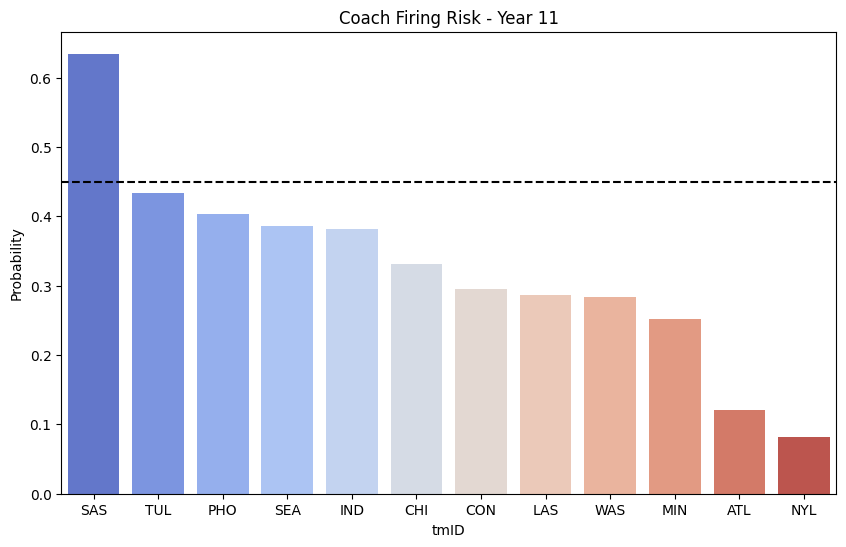

In [8]:
# ===============================================================
# COACH CHANGE PREDICTION — VOTING CLASSIFIER 
# ===============================================================

# Year 11

features = [
    "expectation_gap",
    "coach_award_count",
    "playoff_miss_streak",
    "prev_underperformance",
    "tenure",
    "momentum"
]

target = "mid_season_change"

# Filter for Starters (Min Stint)
min_stints = final_df.groupby(["tmID", "year"])["stint"].transform("min")
valid_data = final_df[final_df["stint"] == min_stints].dropna(subset=[target]).copy()

target_year = 11
train_data = valid_data[valid_data["year"] < target_year]
test_data  = valid_data[valid_data["year"] == target_year]

print(f"Training Ensemble on {len(train_data)} rows.")
print(f"Predicting for {len(test_data)} teams in Year {target_year}.")

X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. MODEL 1: RANDOM FOREST (The "Stability" Expert)

print("\nTraining Model 1: Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=400,
    max_depth=5,
    random_state=42
    )

# 3. MODEL 2: LOGISTIC REGRESSION (The "Ranking" Expert)

print("Training Model 2: Logistic Regression...")

lr_model = LogisticRegression(
    solver='liblinear', 
    C=1.0, 
    class_weight={0: 1, 1: 5}, 
    random_state=42
)

# 4. Model 3: Gradient Boosting Classifier (The "Balanced" Expert)

print("Training Model 3: Gradient Boosting Classifier...")

clf_model = GradientBoostingClassifier(
    n_estimators=150, 
    learning_rate=0.1, 
    max_depth=3, 
    random_state=42
)  

# 5. VOTING CLASSIFIER ENSEMBLE
voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('lr', lr_model),
        ('gbc', clf_model)
    ],
    voting='soft', 
    weights=[1, 1, 1]  
)


weights = compute_sample_weight(class_weight='balanced', y=y_train)

voting_clf.fit(X_train_scaled, y_train, sample_weight=weights)

test_data = test_data.copy()
test_data["prob_ensemble"] = voting_clf.predict_proba(X_test_scaled)[:, 1]


threshold = 0.45
test_data["predicted_change"] = (test_data["prob_ensemble"] > threshold).astype(int)

# 5. Final Output

print("\n" + "="*50)
print(f"PREDICTIONS FOR YEAR {target_year}")
print("="*50)

print("Teams predicted to change coaches:")
predicted_teams = test_data[test_data["predicted_change"] == 1].sort_values("prob_ensemble", ascending=False)
print(predicted_teams[["tmID", "coachID", "prob_ensemble"]])



plt.figure(figsize=(10, 6))
sns.barplot(data=test_data.sort_values("prob_ensemble", ascending=False), x="tmID", y="prob_ensemble", palette="coolwarm")
plt.axhline(threshold, color='black', linestyle='--', label=f'Threshold {threshold}')
plt.title(f"Coach Firing Risk - Year {target_year}")
plt.ylabel("Probability")
plt.show()

Running Backtest Loop for Years: [3, 4, 5, 6, 7, 8, 9, 10]

Average Metrics (Years 3-10):
AUC          0.544369
F1           0.362500
Precision    0.437500
Recall       0.333333
Spearman     0.062268
Accuracy     0.805203
dtype: float64

Detailed Results:
   Year       AUC   F1  Precision    Recall  Spearman  Accuracy  \
0     3  0.000000  0.0        0.0  0.000000 -0.677365  0.562500   
1     4  0.875000  0.5        0.5  0.500000  0.455733  0.857143   
2     5  0.633333  0.4        0.5  0.333333  0.195180  0.769231   
3     6  0.636364  0.5        0.5  0.500000  0.170941  0.846154   
4     7  1.000000  1.0        1.0  1.000000  0.447214  1.000000   
5     8  0.333333  0.0        0.0  0.000000 -0.154303  0.846154   
6     9  0.076923  0.0        0.0  0.000000 -0.378412  0.714286   
7    10  0.800000  0.5        1.0  0.333333  0.439155  0.846154   

    Predicted_Teams_Set  
0  {NYL, UTA, MIA, WAS}  
1            {SAC, PHO}  
2            {LAS, WAS}  
3            {DET, CHA}  
4         

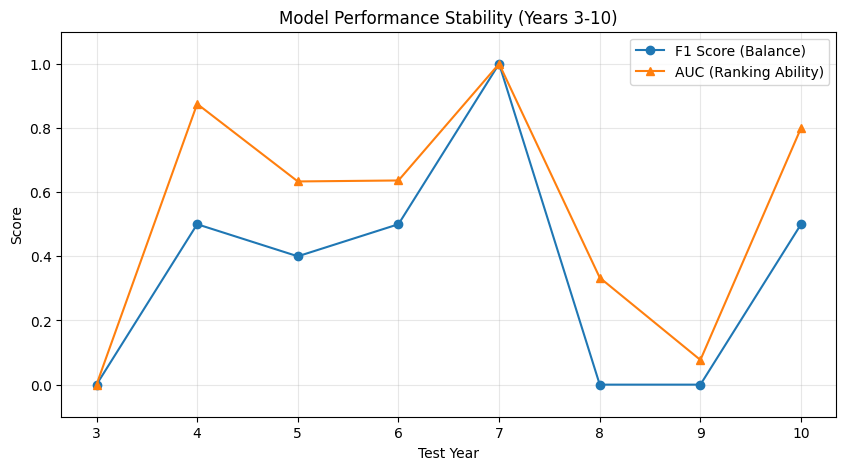

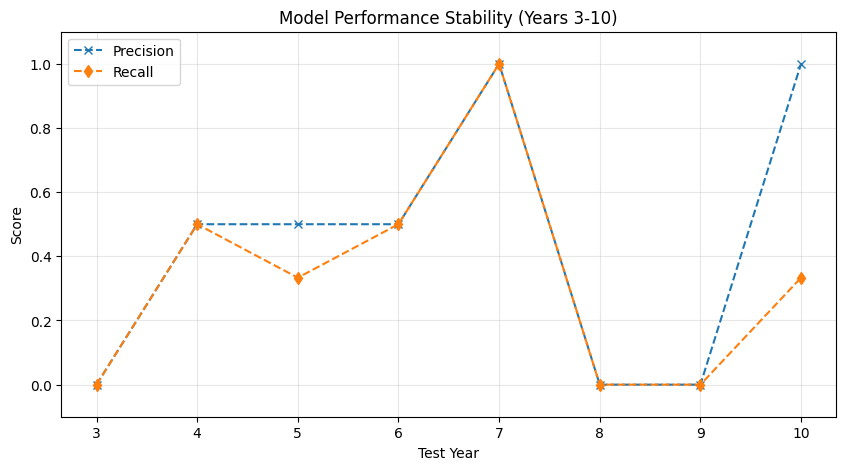

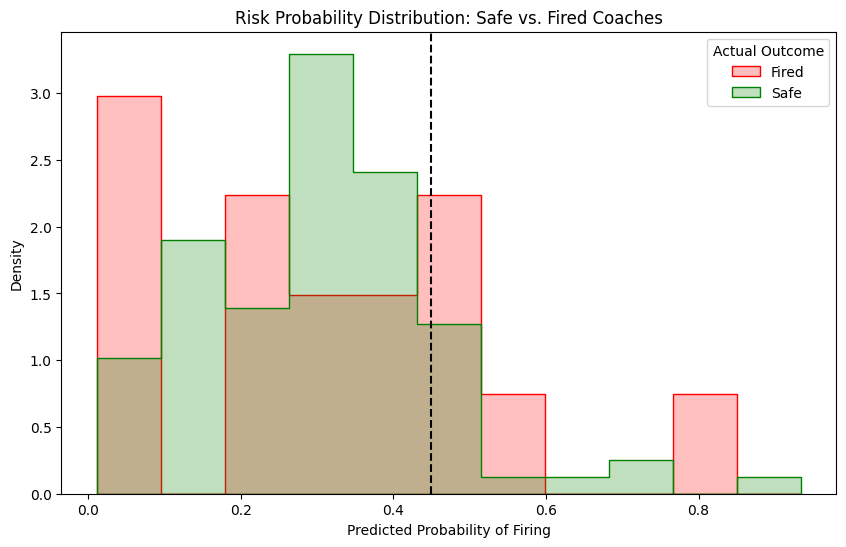

In [9]:
# ===============================================================
# COACH CHANGE PREDICTION — STATISTICS ACROSS YEARS
# ===============================================================


# 1. SETUP & DATA
# ===============================================================
features = [
    "expectation_gap",
    "coach_award_count",
    "playoff_miss_streak",
    "prev_underperformance",
    "tenure",
    "momentum"
]

target = "mid_season_change"

# Filter for Starters (Min Stint)
min_stints = final_df.groupby(["tmID", "year"])["stint"].transform("min")
valid_data = final_df[final_df["stint"] == min_stints].dropna(subset=[target]).copy()

# 2. RUN LOOP FOR YEARS 3 TO 10
# ===============================================================
years_to_test = list(range(3, 11))
results_list = []
all_test_data = pd.DataFrame() # Store all predictions for plotting

print(f"Running Backtest Loop for Years: {years_to_test}")

for year in years_to_test:
    train = valid_data[valid_data["year"] < year]
    test = valid_data[valid_data["year"] == year]
    
    if len(test) == 0: continue

    X_train = train[features]
    y_train = train[target]
    X_test = test[features]
    y_test = test[target]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Model 1: Random Forest
    rf_model = RandomForestClassifier(
        n_estimators=400,
        max_depth=5,
        random_state=42
    )

    # Model 2: Logistic Regression
    lr_model = LogisticRegression(
        solver='liblinear',
        C=1.0,
        class_weight={0: 1, 1: 5},
        random_state=42
    )
    
    # Model 3: Gradient Boosting
    gb_model = GradientBoostingClassifier(
        n_estimators=150,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    )

    # Voting Classifier Ensemble
    ensemble = VotingClassifier(
        estimators=[
            ('rf', rf_model),
            ('lr', lr_model),
            ('gb', gb_model)
        ],
        voting='soft',
        weights=[1, 1, 1]  
    )

    weights = compute_sample_weight(class_weight='balanced', y=y_train)

    ensemble.fit(X_train_scaled, y_train, sample_weight=weights)
    #rf_model.fit(X_train_scaled, y_train, sample_weight=weights)
    #lr_model.fit(X_train_scaled, y_train, sample_weight=weights)
    #gb_model.fit(X_train_scaled, y_train, sample_weight=weights)

    # Store predictions

    test_data = test.copy()
    final_probs = ensemble.predict_proba(X_test_scaled)[:, 1]
    test_data["prob_ensemble"] = final_probs
    threshold = 0.45

    test_data["pred_class"] = (final_probs > threshold).astype(int)
    all_test_data = pd.concat([all_test_data, test_data])

    current_year_teams = test_data.loc[test_data["pred_class"] == 1, "tmID"].unique()

    # Metrics
    metrics = {
        "Year": year,
        "AUC": roc_auc_score(y_test, final_probs) if len(y_test.unique()) > 1 else 0,
        "F1": f1_score(y_test, test_data["pred_class"], zero_division=0),
        "Precision": precision_score(y_test, test_data["pred_class"], zero_division=0),
        "Recall": recall_score(y_test, test_data["pred_class"], zero_division=0),
        "Spearman": spearmanr(y_test, final_probs)[0],
        "Accuracy": accuracy_score(y_test, test_data["pred_class"]),
        "Predicted_Teams_Set": set(current_year_teams)
    }
    results_list.append(metrics)

# 3. AVERAGE STATISTICS
# ===============================================================
results_df = pd.DataFrame(results_list)
avg_metrics = results_df.drop(columns=["Year"]).mean(numeric_only=True)

print("\nAverage Metrics (Years 3-10):")
print(avg_metrics)
print("\nDetailed Results:")
print(results_df)



# 5. ADDITIONAL PLOT A: METRIC STABILITY ACROSS YEARS
# ===============================================================
# Shows if the model is consistent or fluctuates
plt.figure(figsize=(10, 5))
plt.plot(results_df["Year"], results_df["F1"], marker='o', label='F1 Score (Balance)')
plt.plot(results_df["Year"], results_df["AUC"], marker='^', label='AUC (Ranking Ability)')
plt.title("Model Performance Stability (Years 3-10)")
plt.xlabel("Test Year")
plt.ylabel("Score")
plt.ylim(-0.1, 1.1)
plt.xticks(years_to_test)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(results_df["Year"], results_df["Precision"], marker='x', linestyle='--', label='Precision')
plt.plot(results_df["Year"], results_df["Recall"], marker='d', linestyle='--', label='Recall')
plt.title("Model Performance Stability (Years 3-10)")
plt.xlabel("Test Year")
plt.ylabel("Score")
plt.ylim(-0.1, 1.1)
plt.xticks(years_to_test)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 6. ADDITIONAL PLOT B: RISK DISTRIBUTION 
# ===============================================================
# Does the model successfully separate Fired (1) from Safe (0)?
plt.figure(figsize=(10, 6))
sns.histplot(data=all_test_data, x="prob_ensemble", hue="mid_season_change", element="step", stat="density", common_norm=False, palette={0: "green", 1: "red"})
plt.axvline(0.45, color='black', linestyle='--', label='Decision Threshold (0.45)')
plt.title("Risk Probability Distribution: Safe vs. Fired Coaches")
plt.xlabel("Predicted Probability of Firing")
plt.legend(title="Actual Outcome", labels=["Fired", "Safe"])
plt.show()

Training Ensemble on 129 rows.
Predicting for 13 teams in Year 10.

Training Model 1: Random Forest...
Training Model 2: Logistic Regression...
Training Model 3: Gradient Boosting Classifier...

Evaluation for year 10:
AUC:       0.800
F1-score:  0.500
Precision: 1.000
Recall:    0.333
Accuracy:  0.846
Spearman:  0.439

Teams predicted to change coaches:
    tmID     coachID  pred_proba
132  SAC  bouceje01w    0.452527

Top predicted coach changes (with actual result):
     pred_proba  predicted_change  mid_season_change
132    0.452527                 1                  1
116    0.387179                 0                  0
58     0.349349                 0                  0
100    0.340120                 0                  1
1      0.325246                 0                  0
153    0.315791                 0                  0
38     0.310640                 0                  1
72     0.266125                 0                  0
14     0.246542                 0                

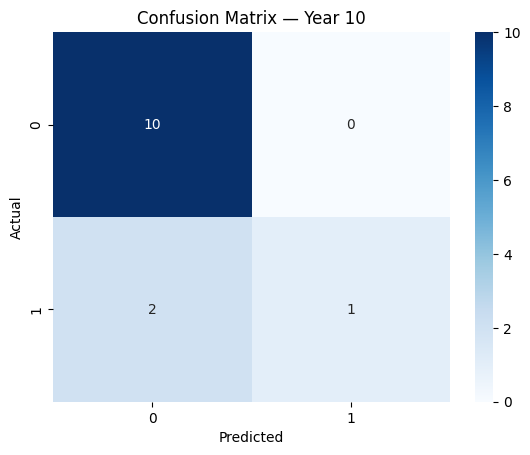

/tmp/ipykernel_28796/170096075.py:152: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance, x="Importance", y="Feature", palette="viridis")


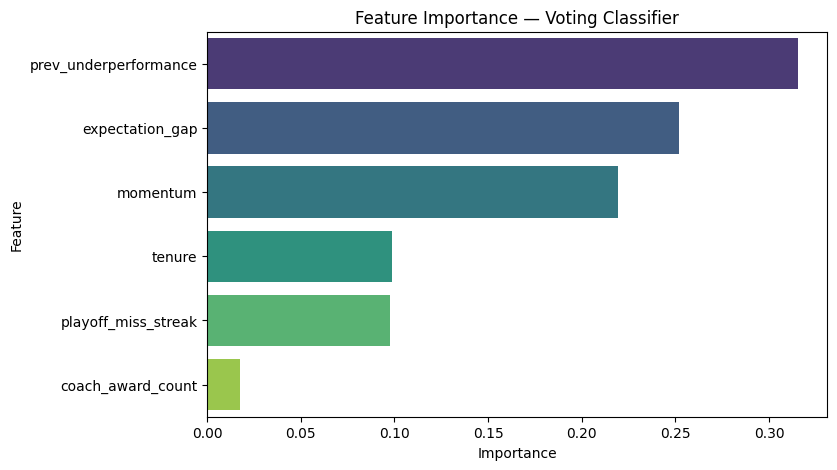


Feature Influence (higher = more impact on firing prediction):
                 Feature  Importance
3  prev_underperformance    0.315219
0        expectation_gap    0.251793
5               momentum    0.219308
4                 tenure    0.098649
2    playoff_miss_streak    0.097652
1      coach_award_count    0.017378


In [10]:
# ===============================================================
# COACH CHANGE PREDICTION — SPECIFIC YEAR DETAILED STATS
# ===============================================================

# Year 10

features = [
    "expectation_gap",
    "coach_award_count",
    "playoff_miss_streak",
    "prev_underperformance",
    "tenure",
    "momentum"
]

target = "mid_season_change"

# Filter for Starters (Min Stint)
min_stints = final_df.groupby(["tmID", "year"])["stint"].transform("min")
valid_data = final_df[final_df["stint"] == min_stints].dropna(subset=[target]).copy()

target_year = 10
train_data = valid_data[valid_data["year"] < target_year]
test_data  = valid_data[valid_data["year"] == target_year]

print(f"Training Ensemble on {len(train_data)} rows.")
print(f"Predicting for {len(test_data)} teams in Year {target_year}.")

X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. MODEL 1: RANDOM FOREST (The "Stability" Expert)

print("\nTraining Model 1: Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=400,
    max_depth=5,
    random_state=42
    )

# 3. MODEL 2: LOGISTIC REGRESSION (The "Ranking" Expert)

print("Training Model 2: Logistic Regression...")

lr_model = LogisticRegression(
    solver='liblinear', 
    C=1.0, 
    class_weight={0: 1, 1: 5}, 
    random_state=42
)

# 4. Model 3: Gradient Boosting Classifier (The "Balanced" Expert)

print("Training Model 3: Gradient Boosting Classifier...")

clf_model = GradientBoostingClassifier(
    n_estimators=150, 
    learning_rate=0.1, 
    max_depth=3, 
    random_state=42
)  

# 5. VOTING CLASSIFIER ENSEMBLE
voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('lr', lr_model),
        ('gbc', clf_model)
    ],
    voting='soft', 
    weights=[1, 1, 1]  
)


weights = compute_sample_weight(class_weight='balanced', y=y_train)

voting_clf.fit(X_train_scaled, y_train, sample_weight=weights)

test_data = test_data.copy()
test_data["prob_ensemble"] = voting_clf.predict_proba(X_test_scaled)[:, 1]


threshold = 0.45
test_data["predicted_change"] = (test_data["prob_ensemble"] > threshold).astype(int)

test_data = test_data.copy()
test_data.loc[:, "pred_proba"] = voting_clf.predict_proba(X_test_scaled)[:, 1]


acc = accuracy_score(y_test, test_data["predicted_change"])
prec = precision_score(y_test, test_data["predicted_change"])
rec = recall_score(y_test, test_data["predicted_change"])
f1 = f1_score(y_test, test_data["predicted_change"])
spearman_corr, spearman_p = spearmanr(y_test, test_data["pred_proba"])
roc_auc = roc_auc_score(y_test, test_data['pred_proba'])


print(f"\nEvaluation for year {target_year}:")
print(f"AUC:       {roc_auc:.3f}")
print(f"F1-score:  {f1:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"Accuracy:  {acc:.3f}")
print(f"Spearman:  {spearman_corr:.3f}")

predicted_teams = test_data[test_data["predicted_change"] == 1].sort_values("pred_proba", ascending=False)

print("\nTeams predicted to change coaches:")
print(predicted_teams[["tmID", "coachID", "pred_proba"]])

print("\nTop predicted coach changes (with actual result):")
print(
    test_data[[
        "pred_proba", "predicted_change", 
        "mid_season_change"
    ]]
    .sort_values("pred_proba", ascending=False)
    .head(test_data.shape[0])
)

# Evaluation


# Confusion Matrix

# Column [0]: probability of class 0: coach stays

# Column [1]: probability of class 1: coach changes/fired


cm = confusion_matrix(y_test, test_data["predicted_change"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix — Year {target_year}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Feature Importance

importance = pd.DataFrame({
    "Feature": features,
    "Importance": voting_clf.named_estimators_.rf.feature_importances_
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=importance, x="Importance", y="Feature", palette="viridis")
plt.title("Feature Importance — Voting Classifier")
plt.show()

print("\nFeature Influence (higher = more impact on firing prediction):")
print(importance)
